In [6]:
from sklearn.model_selection import GridSearchCV, cross_val_score, train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler, LabelEncoder

# Import scores
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import f1_score


# Import classifiers3
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression, RidgeClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC

import pandas as pd
import numpy as np
from datetime import datetime,date
import seaborn as sns

from data_prep_db import data_import_db_simple,select_by_name

In [7]:
### LOADING DATA
db_loc = r'tennis_atp.db'

sql = """SELECT * FROM MATCHES WHERE tourney_level NOT IN ('C','S','F','D','P','PM','I','E','J','T')
    AND tourney_name NOT LIKE '%Olympics%'
    AND tourney_name NOT LIKE '%Cup%'
    AND tourney_name NOT LIKE '%Finals%';"""

# transform matches and return view
df_matches = data_import_db_simple(db_loc,sql)
df_matches['tourney_date'] = pd.to_datetime(df_matches['tourney_date'],format='%Y%m%d')
df_matches['tourney_points'] = df_matches['tourney_level'].map({'A':250,'M':1000,'G':2000}).fillna(0)
df_matches['round_level'] = df_matches['round'].map({'RR':7,'R128':6,'R64':5,'R32':4,'R16':3,'QF':2,'SF':1,'F':0}).fillna(7)
    
# read players and create view
df_players = data_import_db_simple(db_loc,"SELECT * FROM PLAYERS;")
df_players['name'] = df_players['name_first'] + " " + df_players['name_last']
df_players['dob'] = pd.to_datetime(df_players['dob'],format='%Y%m%d',errors='coerce')

# read rankings and create view
df_rankings = data_import_db_simple(db_loc,"SELECT * FROM RANKINGS;")
df_rankings['ranking_date'] = pd.to_datetime(df_rankings['ranking_date'],format='%Y%m%d')


In [8]:
tourns_dict = {}
for i, row in df_matches.groupby(['tourney_name','surface','tourney_points','best_of','draw_size']):
    key = i[0]
    dates = row['tourney_date'].to_list()
    values = list(i[1:])
    keys = ['surface','tourney_points','best_of','draw_size','tourney_dates']
    values.append(dates)
    zip_val = dict(zip(keys,values))
    tourns_dict[key] = zip_val
    tourns_dict[key]

In [9]:
players_dict = {}
for i, row in df_players.groupby(['player_id']):
    name = row['name'].iloc[0]
    players_dict[name] = row.to_dict('records')[0]

In [10]:
players_dict['Nuno Borges']

{'player_id': 132686,
 'name_first': 'Nuno',
 'name_last': 'Borges',
 'hand': 'R',
 'dob': Timestamp('1997-02-19 00:00:00'),
 'ioc': 'POR',
 'height': 185.0,
 'wikidata_id': 'Q106238976',
 'id': 32670,
 'name': 'Nuno Borges'}

In [11]:
id = players_dict['Nuno Borges']['player_id']
matches[(matches['winner_id']==id)|(matches['loser_id']==id)].sort_values(by=['tourney_date','round_level']).T
model_basis[(model_basis['p1_id']==id)|(model_basis['p2_id']==id)].sort_values(by=['tourney_date','round_level']).T

NameError: name 'matches' is not defined

Start Modelling

In [12]:
# select variables to keep
matches = df_matches.copy()

# get data for all matches available
matches['order'] = np.where(matches['winner_rank']<matches['loser_rank'],'p1','p2')
matches['winner_id_final'] = matches['winner_id']

matches = matches[['id','order','winner_id_final',
    'tourney_name','tourney_date','round_level','surface','tourney_points','best_of','draw_size',
    'winner_id', 'winner_hand', 'winner_ht', 'winner_ioc', 'winner_age','winner_rank',
    'loser_id', 'loser_hand','loser_ht', 'loser_ioc', 'loser_age','loser_rank', 
    # 'best_of', 'minutes', 
    # 'w_ace', 'w_df', 'w_svpt', 'w_1stIn', 'w_1stWon', 'w_2ndWon','w_SvGms', 'w_bpSaved', 'w_bpFaced',
    # 'l_ace', 'l_df', 'l_svpt','l_1stIn', 'l_1stWon', 'l_2ndWon', 'l_SvGms', 'l_bpSaved', 'l_bpFaced',
    # 'winner_rank_points', 'loser_rank_points',
    ]]

In [13]:
hand_map = {'R':0,'L':1,'U':-1}
surface_map = {'Hard':0,'Clay':1,'Grass':2,'Carpet':4}

losers_ioc = matches['loser_ioc']
winners_ioc = matches['winner_ioc']
all_countries = pd.concat([losers_ioc,winners_ioc])
all_countries = all_countries.unique()

le = LabelEncoder()
a = le.fit_transform(all_countries)
countries_map = {}
countries_map = dict(zip(all_countries,a))


matches['winner_hand'] = matches['winner_hand'].map(hand_map).fillna(-1)
matches['loser_hand'] = matches['loser_hand'].map(hand_map).fillna(-1)
matches['surface'] = matches['surface'].map(surface_map).fillna(-1)

# matches['winner_entry'] = np.where(matches['winner_entry'].isna(),1,0)
# matches['loser_entry'] = np.where(matches['loser_entry'].isna(),1,0)

matches['loser_ioc'] = matches['loser_ioc'].map(countries_map).fillna(-1)
matches['winner_ioc'] = matches['winner_ioc'].map(countries_map).fillna(-1)

In [14]:
vars_feats = ['id','order','winner_id_final','tourney_name','tourney_date','round_level','surface','tourney_points','best_of','draw_size']

players_data = matches.melt(id_vars=vars_feats)


players_data[['winner_loser','col_name']] = players_data['variable'].str.split("_",expand=True,n=1)

players_data['col_name'] = np.where(players_data['col_name'].isna(),players_data['winner_loser'],players_data['col_name'])

cond_1 = (players_data['winner_loser']=='winner') & (players_data['order']=='p1')
cond_2 = (players_data['winner_loser']=='loser') & (players_data['order']=='p2')

players_data['final_name'] = np.where(cond_1|cond_2,'p1_' + players_data['col_name'],'p2_' + players_data['col_name'])

vars_feats = [v for v in vars_feats if v!='order']
model_basis = players_data.pivot_table(index=vars_feats,columns='final_name',values='value').reset_index()

model_basis['result'] = np.where(model_basis['winner_id_final']==model_basis['p1_id'],1,0)

In [18]:
kpis[kpis['player_id']==104745]

final_name,match_id,win,loss,win_loss_ratio_start,win_last_10,loss_last_10,win_loss_ratio_last_10,win_perc,player_id
9,10658,0,1,0.666667,4.0,6.0,0.666667,0.400000,104745.0
10,10957,1,0,0.833333,4.0,6.0,0.666667,0.454545,104745.0
11,10978,1,0,1.000000,5.0,5.0,1.000000,0.500000,104745.0
12,10988,0,1,0.857143,5.0,5.0,1.000000,0.461538,104745.0
13,11028,1,0,1.000000,5.0,5.0,1.000000,0.500000,104745.0
...,...,...,...,...,...,...,...,...,...
1209,68133,1,0,5.111111,8.0,2.0,4.000000,0.836364,104745.0
1210,68141,0,1,5.085427,7.0,3.0,2.333333,0.835673,104745.0
1211,68581,0,1,5.060000,6.0,4.0,1.500000,0.834983,104745.0
1212,69004,1,0,5.065000,6.0,4.0,1.500000,0.835120,104745.0


In [17]:
all_players_id = players_data[players_data['variable'].isin(['winner_id','loser_id'])]['value'].unique()

# calculate kpis
kpis = pd.DataFrame()
for p_id in all_players_id:
    cond = (model_basis['p1_id']==p_id) | (model_basis['p2_id']==p_id)
    games_for_p = model_basis[cond].copy()

    games_for_p['win'] = np.where(games_for_p['winner_id_final']==p_id,1,0)
    games_for_p['loss'] = np.where(games_for_p['winner_id_final']!=p_id,1,0)
    games_for_p = games_for_p.sort_values(by=['tourney_date','round_level'])
    
    gp = games_for_p.groupby(['id']).agg({'win':'sum','loss':'sum'}).reset_index()

    gp['win_loss_ratio_start'] = np.where(gp['loss'].cumsum()==0,np.nan,gp['win'].cumsum()/gp['loss'].cumsum())

    gp['win_last_10'] = gp['win'].rolling(10).sum()
    gp['loss_last_10'] = gp['loss'].rolling(10).sum()

    gp['win_loss_ratio_last_10'] = np.where(gp['loss_last_10']==0,np.nan,gp['win_last_10']/gp['loss_last_10'])
    
    gp['win_perc'] = gp['win'].cumsum()/(gp['loss'].cumsum()+gp['win'].cumsum())

    gp['player_id'] = p_id
    gp = gp.rename(columns={'id':'match_id'})

    kpis = pd.concat([gp,kpis])


print(f'ini {kpis.shape[0]}')
kpis = kpis.dropna()
print(f'fim {kpis.shape[0]}')

# join kpis with model_basis
model = model_basis.drop(columns=['winner_id_final']).copy()

kpis_p1 = kpis.copy()
kpis_p1.columns = ["p1_" + k for k in kpis_p1.columns]

kpis_p2 = kpis.copy()
kpis_p2.columns = ["p2_" + k for k in kpis_p2.columns]

model = model.merge(kpis_p1,left_on=['p1_id','id'], right_on=['p1_player_id','p1_match_id'],how='left')
model = model.merge(kpis_p2,left_on=['p2_id','id'],right_on=['p2_player_id','p2_match_id'],how='left')

model = model.dropna()

model = model.drop(columns=['p1_player_id','p2_player_id','p1_match_id','p2_match_id','p1_win','p2_win','p1_loss','p2_loss','p1_win_last_10','p2_win_last_10','p1_loss_last_10','p2_loss_last_10'])

ini 128018
fim 117990


Start Model

In [138]:
def prep_model(model,p1,p2,tournament):

    model_date = model[model['tourney_date']<=tournament['tourney_date']].copy()

    # add data for predicting match        
    all_feats = ['id',
                    'tourney_name','tourney_date','round_level','surface','tourney_points','best_of','draw_size',
                    'p1_id', 'p1_ioc', 'p1_rank', 'p1_age', 'p1_hand', 'p1_ht', 'p1_win_loss_ratio_last_10','p1_win_loss_ratio_start','p1_win_perc',
                    'p2_id','p2_ioc', 'p2_rank', 'p2_age', 'p2_hand', 'p2_ht','p2_win_loss_ratio_last_10','p2_win_loss_ratio_start','p2_win_perc',]

    match_id = model_date['id'].max()+1
    list_input = [match_id,
                    tournament['tourney_name'], tournament['tourney_date'], tournament['round_level'],
                    tournament['surface'],tournament['tourney_points'], tournament['best_of'],tournament['draw_size'],
                    p1['player_id'],p1['ioc'],p1['last_rank'],p1['age'],p1['hand'],p1['height'],p1['win_loss_ratio_last_10'],p1['win_loss_ratio_start'],p1['win_perc'],
                    p2['player_id'],p2['ioc'],p2['last_rank'],p2['age'],p2['hand'],p2['height'],p2['win_loss_ratio_last_10'],p2['win_loss_ratio_start'],p2['win_perc']
                    ]


    input_match = pd.DataFrame([list_input],columns=all_feats)

    input_match['p1_hand'] = input_match['p1_hand'].map(hand_map).fillna(-1)
    input_match['p2_hand'] = input_match['p2_hand'].map(hand_map).fillna(-1)
    input_match['surface'] = input_match['surface'].map(surface_map).fillna(-1)
    input_match['p1_ioc'] = input_match['p1_ioc'].map(countries_map).fillna(-1)
    input_match['p2_ioc'] = input_match['p2_ioc'].map(countries_map).fillna(-1)
    input_match['result'] = 0 
    
    model_to_predict = pd.concat([model_date,input_match])

    model_to_predict = model_to_predict
    model_to_predict = model_to_predict.set_index('id')

    model_to_predict['time_since'] = (datetime.now() - pd.to_datetime(model_to_predict['tourney_date'],format='%Y-%m-%d')).dt.days

    cond_1 = model_to_predict['p1_id']==p1['player_id']
    cond_2 = model_to_predict['p2_id']==p2['player_id']

    cond_3 = model_to_predict['p1_id']==p2['player_id']
    cond_4 = model_to_predict['p2_id']==p1['player_id']

    model_to_predict['h2h'] = np.where((cond_1)&(cond_2),1,
                                np.where((cond_3)&(cond_4),1,0))
    
    return model_to_predict

def scale_model(model):
    new_dataset = model.copy()
    new_dataset = new_dataset.drop(columns='tourney_date')
    
    # encoding using one hot encoder
    cols_ohe = ['surface']
    one_hot_encoded_data = pd.get_dummies(new_dataset[cols_ohe], columns = cols_ohe) 
    one_hot_encoded_data = one_hot_encoded_data.astype(int)

    cols_le = ['tourney_name']
    le = LabelEncoder()
    tourn_encoded = le.fit_transform(new_dataset['tourney_name'])
    new_dataset['tourney_name'] = tourn_encoded

    ini = new_dataset.shape[0]
    new_dataset = new_dataset.dropna()
    fim = new_dataset.shape[0]
    print(f'Dropped: {fim-ini}|{(fim-ini)/ini:.2%}')

    result = new_dataset['result'].copy()
    new_dataset = new_dataset.drop(columns=['result'])
    new_dataset = new_dataset.drop(columns=cols_ohe)
    # new_dataset = new_dataset.drop(columns=cols_le)

    cols_to_scale = new_dataset.columns

    scl = StandardScaler()
    matches_scaled = scl.fit_transform(new_dataset)


    df_scaled = pd.DataFrame(matches_scaled,columns=cols_to_scale,index=new_dataset.index)

    model_scaled = pd.concat([result,one_hot_encoded_data,df_scaled],axis=1)

    ini = model_scaled.shape[0]
    model_scaled = model_scaled.dropna()
    fim = model_scaled.shape[0]
    
    return model_scaled

In [139]:
class TennisPredModel():

    def __init__(self,dataset):
        self.dataset = dataset
    
    def split_model(self,train_size_val=0.8,random_state_val=10):
        match_to_predict = pd.DataFrame(self.dataset.iloc[-1]).T
        matches_ready = self.dataset.iloc[0:-1]

        def create_feature_target_var(df):
            # Create feature variable
            X = df.drop('result', axis=1)
            # Create target variable
            y = df['result']
            return X,y
        
        X_to_predict,y_to_predict = create_feature_target_var(match_to_predict)
        X,y = create_feature_target_var(matches_ready)

        # Create training and testing sets
        X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=train_size_val,random_state=random_state_val)

        return X, y, X_train, X_test, y_train, y_test, X_to_predict, y_to_predict


    def hyperparameter_tuning(self,name,X_train,y_train):
        if name=='LogisticRegression':
            # Logistic Regression Classifier
            param_grid = {'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000] }
            model = LogisticRegression()
            log_cv = GridSearchCV(model, param_grid, cv=5)
            log_cv.fit(X_train, y_train)
            model = LogisticRegression(log_cv.best_params_)
            print(f'model {model}: {log_cv.best_params_}')

        elif name =='KNN':
            # KNN - Neighrest Neighbor 
            param_grid = {'n_neighbors': np.arange(1,50),
                          'algorithm':('auto','ball_tree','kd_tree','brute')}
            knn = KNeighborsClassifier()
            knn_cv = GridSearchCV(knn, param_grid, cv=5)
            knn_cv.fit(X_train, y_train)
            model = KNeighborsClassifier(knn_cv.best_params_)
            print(f'model {model}: {knn_cv.best_params_}')
        
        elif name == 'RandomForestClassifier':
            param_grid = {
                'n_estimators': [25,50],
                'max_features': ['sqrt','log2'],
                'max_depth': [3,6,9],
                'max_leaf_nodes': [3,6,9],
            }

            rfc = RandomForestClassifier()
            cv = GridSearchCV(rfc, param_grid, cv = 5)
            cv.fit(X_train, y_train)
            model = RandomForestClassifier(**cv.best_params_)
            print(f'model {model}: {cv.best_params_}')

        elif name == 'DecisionTreeClassifier':
            param_grid = {
                'criterion': ['gini','entropy'],
                'splitter': ['best','random'],
                'max_depth': [50,60,70,80],
            }

            dtc = DecisionTreeClassifier()
            cv = GridSearchCV(dtc, param_grid, cv = 5)
            cv.fit(X_train, y_train)
            model = DecisionTreeClassifier(**cv.best_params_)
            print(f'model {model}: {cv.best_params_}')
    
    def predictive_model(self,model,X_train,y_train,X_test,y_test):
        # Fit to the training data
        model.fit(X_train,y_train)

        # Compute accuracy
        accuracy = model.score(X_test,y_test)
        # print(f'Accuracy: {accuracy:.0%}')

        # Predict the labels of the test set
        y_pred = model.predict(X_test)

        precision = precision_score(y_test,y_pred)
        recall = recall_score(y_test,y_pred)
        # print(f'Precision: {precision:.0%}')
        # print(f'Recall: {recall:.0%}')

        # Generate the probabilities
        y_pred_prob = model.predict_proba(X_test)[:, 1]

        auc = roc_auc_score(y_test, y_pred_prob)
        f1_score_val = f1_score(y_test,y_pred)
        # print(f'AUC: {auc:.0%}')
        # print(f'F1 Score: {f1_score_val:.0%}')

        # # Calculate the roc metrics
        # fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)

        # # Plot the ROC curve
        # plt.plot(fpr,tpr)

        # # Add labels and diagonal line
        # plt.xlabel("False Positive Rate")
        # plt.ylabel("True Positive Rate")
        # plt.plot([0, 1], [0, 1], "k--")
        # plt.show()

        return [accuracy,precision,recall,auc,f1_score_val], y_pred

    def pick_best_model(self,X_train,y_train,X_test,y_test):
        #LogisticRegression, KNN não fazem fit
        classifiers = [RandomForestClassifier(),DecisionTreeClassifier()]
        classifiers_names = ['RandomForestClassifier','DecisionTreeClassifier']

        # classifiers = classifiers[2:3]
        # classifiers_names = classifiers_names[2:3]
        dict_classifiers = dict(zip(classifiers_names, classifiers))
        
        results = {}
        predictions = {}
        best_score = 0
        best_model = ""
        for name, clf in dict_classifiers.items():
            print(f'Predicting using {name}')
            self.hyperparameter_tuning(name, X_train, y_train)
            scores, y_pred = self.predictive_model(clf, X_train, y_train, X_test, y_test)
            
            results[name] = scores
            predictions[name] = y_pred
            preci = scores[1]
            recall = scores[2]
            score = preci * recall
            print(f'{name} score is {score:.4f} | Precision {preci:.2f} | Recall {recall:.2f}')
            if score >= best_score:
                best_score = score
                best_model = name
            print(f'Current Best model {best_model}\n')

        model_selected = dict_classifiers[name]
        print(f'Model Selected: {best_model} with score {best_score:.4f}\n')
        
        return model_selected,best_model,preci,recall

    def predictive_model_apply(self,model,X,y,X_to_predict):
        # Fit to the training data

        model.fit(X,y)
        self.model = model

        # Predict the labels of the test set
        y_pred = model.predict(X_to_predict)

        prob = model.predict_proba(X_to_predict)[:, 1]
        feat_imp =  model.feature_importances_

        return y_pred,prob,feat_imp


In [182]:
# Define inputs
name_b = 'Daniil Medvedev'
name_a = 'Jannik Sinner'
tournament_name = 'US Open'
tournament_date = pd.to_datetime('2024-01-24',format='%Y-%m-%d')
round_level = 7

In [183]:
#MAIN
pa = players_dict[name_a]
pb = players_dict[name_b]

tournament = tourns_dict[tournament_name]
tournament['tourney_date'] = tournament_date
tournament['round_level'] = round_level
tournament['tourney_name'] = tournament_name

rankings_date = df_rankings[df_rankings['ranking_date']<=tournament_date].copy()

last_rank_date = rankings_date.groupby(['player'])['ranking_date'].max().reset_index()
last_rank = rankings_date.merge(last_rank_date,on=['player','ranking_date'],how='inner')

pa['last_rank'] = last_rank[last_rank['player']==pa['player_id']]['rank'].iloc[0]
pb['last_rank'] = last_rank[last_rank['player']==pb['player_id']]['rank'].iloc[0]

if pa['last_rank']<pb['last_rank']:
    p1 = pa
    p2 = pb
else:
    p2 = pa
    p1 = pb

p1['age'] = int((tournament_date-p1['dob']).days)//365
p2['age'] = int((tournament_date-p2['dob']).days)//365

p1_kpis = kpis[kpis['player_id']==p1['player_id']].sort_values(by='match_id')
p1_kpis = p1_kpis.iloc[-1][['win_loss_ratio_start','win_loss_ratio_last_10','win_perc']]
p1.update(p1_kpis.to_dict())

p2_kpis = kpis[kpis['player_id']==p2['player_id']].sort_values(by='match_id')
p2_kpis = p2_kpis.iloc[-1][['win_loss_ratio_start','win_loss_ratio_last_10','win_perc']]
p2.update(p2_kpis.to_dict())

model_to_predict = prep_model(model,p1,p2,tournament)
model_scaled = scale_model(model_to_predict)

Dropped: 0|0.00%


In [184]:
kpis[kpis['player_id']==207989].sort_values(by='match_id')

final_name,match_id,win,loss,win_loss_ratio_start,win_last_10,loss_last_10,win_loss_ratio_last_10,win_perc,player_id
9,63577,0,1,1.500000,6.0,4.0,1.500000,0.600000,207989.0
10,63641,0,1,1.200000,6.0,4.0,1.500000,0.545455,207989.0
11,63754,0,1,1.000000,5.0,5.0,1.000000,0.500000,207989.0
12,64071,0,1,0.857143,5.0,5.0,1.000000,0.461538,207989.0
13,64136,0,1,0.750000,4.0,6.0,0.666667,0.428571,207989.0
...,...,...,...,...,...,...,...,...,...
181,71213,1,0,3.789474,8.0,2.0,4.000000,0.791209,207989.0
182,71236,0,1,3.692308,7.0,3.0,2.333333,0.786885,207989.0
183,71244,1,0,3.717949,7.0,3.0,2.333333,0.788043,207989.0
184,71260,1,0,3.743590,7.0,3.0,2.333333,0.789189,207989.0


In [185]:
model_to_predict[(model_to_predict['p1_id']==207989.0)|(model_to_predict['p2_id']==207989.0)].T

id,63577,63641,63754,64071,64136,64232,64242,64248,64251,64252,...,71110,71114,71199,71201,71205,71213,71236,71244,71260,71501
tourney_name,Paris Masters,Miami Masters,Indian Wells Masters,Cincinnati Masters,Barcelona,Umag,Umag,Umag,Umag,Umag,...,Us Open,Us Open,Beijing,Beijing,Beijing,Beijing,Shanghai Masters,Shanghai Masters,Shanghai Masters,Paris Masters
tourney_date,2021-11-01 00:00:00,2021-03-22 00:00:00,2021-10-04 00:00:00,2021-08-16 00:00:00,2021-04-19 00:00:00,2021-07-19 00:00:00,2021-07-19 00:00:00,2021-07-19 00:00:00,2021-07-19 00:00:00,2021-07-19 00:00:00,...,2023-08-28 00:00:00,2023-08-28 00:00:00,2023-09-27 00:00:00,2023-09-27 00:00:00,2023-09-27 00:00:00,2023-09-27 00:00:00,2023-10-02 00:00:00,2023-10-02 00:00:00,2023-10-02 00:00:00,2023-10-30 00:00:00
round_level,3.0,6.0,5.0,5.0,5.0,4.0,3.0,2.0,1.0,0.0,...,2.0,1.0,1.0,2.0,3.0,4.0,3.0,4.0,5.0,4.0
surface,0,0,0,0,1,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0
tourney_points,1000,1000,1000,1000,250,250,250,250,250,250,...,2000,2000,250,250,250,250,1000,1000,1000,1000
best_of,3,3,3,3,3,3,3,3,3,3,...,5,5,3,3,3,3,3,3,3,3
draw_size,64,128,128,64,64,32,32,32,32,32,...,128,128,32,32,32,32,128,128,128,64
p1_age,18.4,21.9,18.4,26.2,23.2,18.2,18.2,29.3,33.5,35.0,...,20.3,20.3,20.3,20.3,20.3,20.3,20.4,20.4,20.4,20.4
p1_hand,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
p1_ht,185.0,188.0,185.0,191.0,188.0,185.0,185.0,185.0,188.0,185.0,...,185.0,185.0,185.0,185.0,185.0,185.0,185.0,185.0,185.0,185.0


In [186]:
tc = TennisPredModel(model_scaled)

X, y, X_train, X_test, y_train, y_test, X_to_predict, y_to_predict = tc.split_model()

print(f'Data model and features ready')
# model_selected,model_name,preci,recall = tc.pick_best_model(X_train, y_train, X_test, y_test)
params = {'max_depth': 6, 'max_features': 'sqrt', 'max_leaf_nodes': 9, 'n_estimators': 25}
# params = {'max_depth': 9, 'max_features': 'sqrt', 'max_leaf_nodes': 9, 'n_estimators': 25}
model_selected = RandomForestClassifier(**params)
result, probability, feat_importance = tc.predictive_model_apply(model_selected,X,y,X_to_predict)

Data model and features ready


Daniil Medvedev is going to win the match against Jannik Sinner with a probability of 64.24%!
[1]


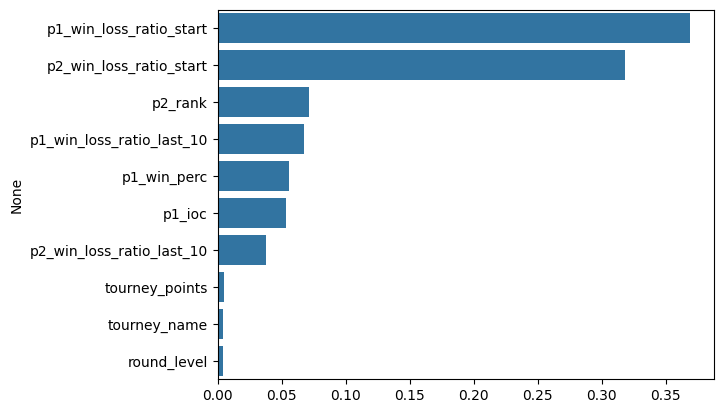

In [187]:
p1_rank = p1['last_rank']
p2_rank = p2['last_rank']
p1_id = p1['player_id']
p2_id = p2['player_id']

if result[0] == 1:
    # ganhou quem tem ranking mais alto
    if p1_rank < p2_rank:
        winner = p1
    else:
        winner = p2
else:
    # ganhou quem tem ranking mais baixo
    if p1_rank < p2_rank:
        winner = p2
    else:
        winner = p1

winner_name = winner['name']
if winner == p1:
    loser_name = p2['name']
else:
    loser_name = p1['name']

    # Finally, we’ll visualize these values using a bar chart:

import seaborn as sns

# Sort the feature importances from greatest to least using the sorted indices
sorted_indices = feat_importance.argsort()[::-1]
sorted_feature_names = tc.dataset.columns[sorted_indices]
sorted_importances = feat_importance[sorted_indices]

# Create a bar plot of the feature importances
sns.barplot(x=sorted_importances[0:10],y=sorted_feature_names[0:10])
df = pd.DataFrame(sorted_importances,sorted_feature_names)
print(f'{winner_name} is going to win the match against {loser_name} with a probability of {probability[0]:.2%}!')

print(result)